## 0. Colab Environment Settings

In [1]:
#Authentication for google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
#check the validity of the project path
!ls "/gdrive/My Drive/text-generation-lstm-keras/"

character_level.ipynb  ekonomi-saglik-spor.txt	saved_models


In [3]:
#set as a current directory
import os
os.chdir("/gdrive/My Drive/text-generation-lstm-keras/")

## 1. Import Libraries and The Dataset

In [4]:
'''
At least 20 epochs are required before the generated text
starts sounding coherent.
It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.
If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
import random
import sys
import io


In [5]:
#open the file
filename = 'ekonomi-saglik-spor.txt'
with io.open(filename,encoding="ISO-8859-9") as f:
    text = f.read().lower()
print('corpus length:', len(text))

corpus length: 461527


In [6]:
print(text[0:500])

 ankara - türk telekom'un indirim reklamları sanayi ve ticaret bakanlığı'na takıldı. sanayi ve ticaret bakanlığı tüketicinin ve rekabetin korunması genel müdürlüğü bünyesinde yer alan reklam kurulu, türk telekom'un 1 ağustos'tan itibaren yürürlüğe koyduğu yeni tarifelerine ilişkin olarak 'telefon yüzde 80 ucuzluyor' sloganını taşıyan tv ve basın reklamlarına 'tüketici yanıltılıyor' gerekçesiyle ihtiyati tedbir niteliğinde durdurma cezası verdi. kurul kararını türk telekom'a tebliğ edecek. kurul 


## 2. Data Cleaning

In [7]:
#cleaning undesired characters
from string import punctuation, digits
translator = str.maketrans('', '', punctuation)
text = text.translate(translator)
translator = str.maketrans('', '', digits)
text = text.translate(translator)
translator = str.maketrans('', '', '\x85'+ '\x91'+ '\x92'+ '\x93'+ '\x94'+ '\x95'+ '´'+ '·')
text = text.translate(translator)
others = {'á' : 'a', 'â':'a', 'î':'i', 'ô':'o', '\n':' '}
translator = str.maketrans(others)
text = text.translate(translator)


print(text[0:500])

 ankara  türk telekomun indirim reklamları sanayi ve ticaret bakanlığına takıldı sanayi ve ticaret bakanlığı tüketicinin ve rekabetin korunması genel müdürlüğü bünyesinde yer alan reklam kurulu türk telekomun  ağustostan itibaren yürürlüğe koyduğu yeni tarifelerine ilişkin olarak telefon yüzde  ucuzluyor sloganını taşıyan tv ve basın reklamlarına tüketici yanıltılıyor gerekçesiyle ihtiyati tedbir niteliğinde durdurma cezası verdi kurul kararını türk telekoma tebliğ edecek kurul kesin durdurma ka


## 3. Vectorization of Text for Training

In [8]:
chars = sorted(list(set(text)))
print(chars)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 50
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ç', 'ö', 'ü', 'ğ', 'ı', 'ş', '̇']
total chars: 34
nb sequences: 148115
Vectorization...


## 4. Model Building

In [9]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


### 4.1. Utility Functions

In [10]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each 2 epoch. Prints generated text.
    epoch +=1
    if(epoch % 2 == 0):
      print()
      print('----- Generating text after Epoch: %d' % epoch)

      start_index = random.randint(0, len(text) - maxlen - 1)
      for diversity in [0.2, 0.5, 1.0, 1.2]:
          print('----- diversity:', diversity)

          generated = ''
          sentence = text[start_index: start_index + maxlen]
          generated += sentence
          print('----- Generating with seed: "' + sentence + '"')
          sys.stdout.write(generated)

          for i in range(175):
              x_pred = np.zeros((1, maxlen, len(chars)))
              for t, char in enumerate(sentence):
                  x_pred[0, t, char_indices[char]] = 1.

              preds = model.predict(x_pred, verbose=0)[0]
              next_index = sample(preds, diversity)
              next_char = indices_char[next_index]

              sentence = sentence[1:] + next_char

              sys.stdout.write(next_char)
              sys.stdout.flush()
          print()

    model.save('saved_models/model_{}epochs'.format(epoch))

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


## 5. Training

In [11]:
epochs = 25
batch_size = 128


history_callback = model.fit(x, y,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[print_callback])

Epoch 1/25
1157/1158 [============================>.] - ETA: 0s - loss: 2.2396WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/model_1epochs/assets
1158/1158 [==============================] - 20s 17ms/step - loss: 2.2395
Epoch 2/25
1157/1158 [============================>.] - ETA: 0s - loss: 1.8134
----- Generating text after Epoch: 2
----- diversity: 0.2
----- Generating with seed: "ğı cezaya değindi ayala habersiz gitmesi profesyon"
ğı cezaya değindi ayala habersiz gitmesi profesyon kaynak doğuşlarını belirtildi         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


                                                                                                                                           
----- diversity: 0.5
----- Generating with seed: "ğünü yaklaşık  milyar dolar olarak tahmin ediyoruz"
ğünü yaklaşık  milyar dolar olarak tahmin ediyoruz bir konusunda genel kurulmuş satınız  sınırlık bir maçta kartılaşıldığı göre gerekiyor                            ben kaynaklanan takımı ile gaçın de yapmak için yetiştiren d
----- diversity: 1.0
----- Generating with seed: "ğünü yaklaşık  milyar dolar olarak tahmin ediyoruz"
ğünü yaklaşık  milyar dolar olarak tahmin ediyoruz bir da  telefonin artışının işlerine yakından çok aralanmıştı gerektiğini le üründen husımtasını ilk fiyatımı ile bu ölündeki ikince kabul yapısırı olan üstünden ün bir tahil
----- diversity: 1.2
----- Generating with seed: "ğünü yaklaşık  milyar dolar olarak tahmin ediyoruz"
ğünü yaklaşık  milyar dolar olarak tahmin ediyoruz püketiç proverleri yapılan çalışmaya korumadaki ola

In [12]:
loss_history = history_callback.history["loss"]
np.savetxt("saved_models/loss_history.txt",loss_history, delimiter=",")


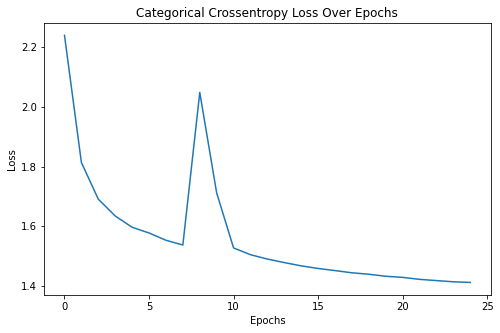

In [14]:
import matplotlib.pyplot as plt

y = loss_history
x = list(range(len(y)))

plt.figure(figsize=(8,5))
plt.plot(x,y)
plt.title("Categorical Crossentropy Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## 6. Testing with a Pre-Trained Model

In [15]:
from tensorflow import keras
model = keras.models.load_model('saved_models/model_25epochs')

In [21]:

def generate_text(seed,diversity,generated_text_len):

  string_length=maxlen 
  sentence = seed.rjust(string_length)
  print()
  print('diversity: '+ str(diversity))
  print(sentence,end='')
  for i in range(generated_text_len):
          x_pred = np.zeros((1, maxlen, len(chars)))
          for t, char in enumerate(sentence):
              x_pred[0, t, char_indices[char]] = 1.

          preds = model.predict(x_pred, verbose=0)[0]
          next_index = sample(preds, diversity)
          next_char = indices_char[next_index]

          sentence = sentence[1:] + next_char

          sys.stdout.write(next_char)
          sys.stdout.flush()
          
np.seterr(divide = 'ignore') 

In [22]:
seed = 'modelin çalışma testi '
generate_text(seed,0.55,150)
generate_text(seed,0.65,150)
generate_text(seed,0.85,150)


diversity: 0.55
                            modelin çalışma testi haline ilk altında ile bir antalya olarak teknik her cildirinin sonucunun için                      takım başkanı tek sürektirilecek sebze kaydedecek 
diversity: 0.65
                            modelin çalışma testi tam bunun yapmalı olacak i̇ki kaya fiyatlarının teknik futleme ancak artış ihtiyacı ve yayını savunması bir yap ve sektörüne ile tempop takımı tekelin
diversity: 0.85
                            modelin çalışma testi sayasında ve takımını sısılan karşı efsayi rebrovler  mi    şu bunun ilaç çıkan buvunun ile ile sonra açık yeri  şirket kara çıkmayı ve yayın efesti  

In [25]:
seed = 'yarım metin örne'
generate_text(seed,0.55,150)
generate_text(seed,0.65,150)
generate_text(seed,0.85,150)



diversity: 0.55
                                  yarım metin örneğin kazayı yağn futbol fiyatı olmadığını belirten ve sisteminin yetkilileri olarak kurulunun sununun ve süre teknik direktörler alıyoruz   tamer etkil
diversity: 0.65
                                  yarım metin örnen sonrasında baskının kalecez ve eken eskişiliğine karşı için ilgilenen ligin bu yaşandığını belirterek palli  yatırıldığı bizden sonuna ulaşılan irac
diversity: 0.85
                                  yarım metin örnek için üçüncü  hükümet sizin merkezi içinde demelenimken güçlü akkiden  milyon dolar ve gözune gelen sonunda koruyacağını belirten yüzde  ilişkin işre